In [1]:
from pg8000.native import Connection
import json
import boto3
from datetime import datetime
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#useful functions
def get_db_credentials():
    secret_name = "postgres_db_credentials"
    region_name = "eu-west-2"

    session = boto3.session.Session()
    client = session.client(service_name="secretsmanager",
                            region_name=region_name)

    get_secret_value_response = client.get_secret_value(SecretId=secret_name)

    secret = json.loads(get_secret_value_response["SecretString"])
    db_credentials = {}
    db_credentials["DB_HOST"] = secret["host"]
    db_credentials["DB_USERNAME"] = secret["username"]
    db_credentials["DB_PASSWORD"] = secret["password"]
    db_credentials["DB_NAME"] = secret["dbname"]

    return db_credentials

def create_connection(db_credentials):
    return Connection(
        user=db_credentials["DB_USERNAME"],
        password=db_credentials["DB_PASSWORD"],
        host=db_credentials["DB_HOST"],
        database=db_credentials["DB_NAME"])

def convert_lists_to_dicts(list_of_lists, keys):
    list_of_dicts = []

    for row in list_of_lists:
        row_as_dict = {
            keys[i]: cell.isoformat(sep=" ", timespec="milliseconds")
            if type(cell) is datetime
            else cell for i,
            cell in enumerate(row)
        }
        list_of_dicts.append(row_as_dict)

    return list_of_dicts

In [3]:
db_credentials = get_db_credentials()
conn = create_connection(db_credentials)

In [10]:
query_result = conn.run("""
select month, sum(units_sold)
from fact_sales_order fso
join dim_date dd
	on fso.created_date = dd.date_id
where year = 2023 and month != 11
group by month
order by month
"""
                       )

In [11]:
column_names = [column["name"] for column in conn.columns]
list_of_dicts = convert_lists_to_dicts(query_result, column_names)
dataframe = pd.DataFrame.from_records(list_of_dicts)
dataframe

,month,sum
0,1,20207498
1,2,22118020
2,3,25324457
3,4,22541033
4,5,25374930
5,6,26782557
6,7,23675144
7,8,24520940
8,9,25209038
9,10,25575805


<Axes: xlabel='month', ylabel='sum'>

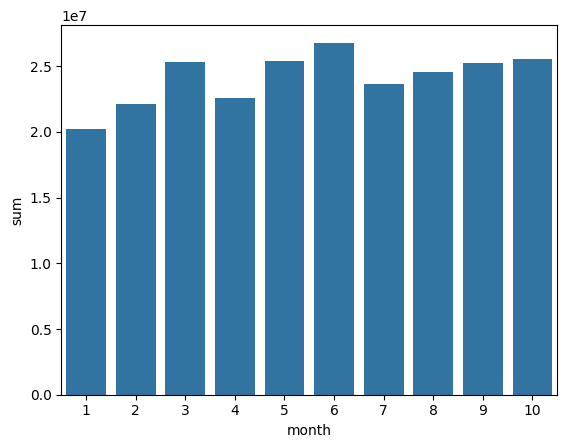

In [12]:
sns.barplot(data=dataframe, x = 'month', y='sum')